#Install Pyspark

In [ ]:
!pip install pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=ecc273a31e767bc4f87fdca60154c74eef9a4edb0f38e4fb39901b1e14105a1a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import findspark
findspark.init()

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
!echo $SPARK_HOME
!echo $JAVA_HOME

/usr/local/lib/python3.10/dist-packages/pyspark
/usr/lib/jvm/java-8-openjdk-amd64


In [ ]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("Final").setMaster("local")
sc = SparkContext(conf=conf)

#Task1 && Task2


##Theory
1. Clustering using KMeans:

- KMeans is a popular clustering algorithm used to divide a data set into K different clusters. The goal of KMeans is to minimize the sum of squared distances between data points and their cluster centers.
- How it works:

  - Initialization: Choose K initial cluster centers (randomly or use a method like KMeans++ to choose better initialization centers).
Cluster assignment: Assign each data point to the cluster with the closest center.
  - Update: Recalculate the cluster center by taking the average of the points in each cluster.
  - Repeat: Repeat the two steps of cluster assignment and update until the cluster center does not change (or changes very little).
  - In the code, MNIST data (handwritten digit image data) is used to cluster into 10 clusters (corresponding to 10 digits from 0 to 9). The code also assigns weights to particular data points, helping the algorithm pay more attention to these points.
- Advantages of K-means:
  - Simplicity and ease of understanding
  - Time efficiency
  - Scalability
  - Effective with spherical clusters
- Disadvantages of K-means:
  - Difficulty in choosing the number of clusters (k)
  - Sensitivity to initial values
  - Limitation to spherical clusters
  - Does not perform well with heterogeneous data
  - Susceptible to outliers and noise
  - Hard clustering
2. TruncatedSVD:
- Truncated SVD (Singular Value Decomposition) is a data dimensionality reduction technique often used in the field of machine learning and big data processing, especially for sparse data. This is a variation of the standard SVD, optimized to handle large matrices without needing to compute the entire covariance matrix.
- How it works:
  - Given a data matrix A of size m×n, SVD decomposes
A into three matrices:
    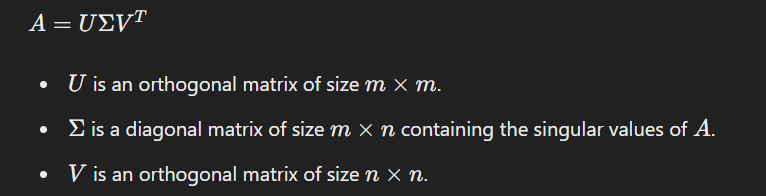
  - Truncated SVD: Truncated SVD retains only k principal components, where k is less than or equal to the dimensionality of the original data. This helps reduce the size of the data while preserving the most important information. Matrix A is approximated by:
  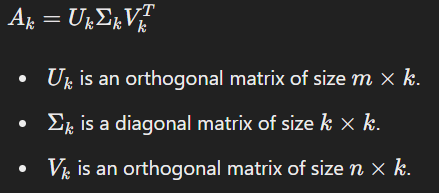
- Advantages of SVD:
  - Effective dimensionality reduction
  - Noise reduction
  - Optimal low-rank approximation
  - Handling of correlated features
  - Applications in diverse fields
- Disadvantages of SVD:
  - Computationally expensive
  - Interpretability issues
  - Sensitivity to data scaling
  - Data requirement
  - Storage requirements


##pseudocode

Class MNISTKMeans


    Constructor(file_path)
        Initialize SparkSession
        Set file_path
        Initialize data, model, transformed_data, reduced_data to None

    Method load_data()
        Read CSV file from file_path
        Assemble features into "features" column
        Select "features" column
        Add "index" column with increasing values

    Method assign_weights()
        Define special_indices
        Define assign_weight UDF
        Apply UDF to create "weight" column

    Method fit_kmeans(k=10)
        Initialize KMeans with k, seed, and weight column
        Fit KMeans model with data
        Transform data with KMeans model to add "prediction" column

    Method compute_average_distances()
        Get cluster centers and broadcast them
        Calculate distances from each point to its cluster center
        Create DataFrame of distances
        Compute average distance per cluster

    Method plot_distances(avg_distances)
        Extract clusters and distances from avg_distances
        Plot bar chart of average distances

    Method plot_clusters()
        Convert transformed_data to Pandas DataFrame
        Apply PCA to reduce dimensions to 2
        Plot scatter plot before clustering
        Plot scatter plot after clustering with centroids

    Method reduce_dimensions()
        Convert transformed_data to Pandas DataFrame
        Apply TruncatedSVD to reduce dimensions to 3
        Create Spark DataFrame from SVD components and predictions

    Method plot_3d_clusters()
        Sample 100 points from reduced_data
        Convert sampled data to Pandas DataFrame
        Plot 3D scatter plot of clusters

    Method run()
        load_data()
        assign_weights()
        fit_kmeans()
        avg_distances = compute_average_distances()
        plot_clusters()
        plot_distances(avg_distances)
        reduce_dimensions()
        plot_3d_clusters()

Main Program
    Create MNISTKMeans instance with 'mnist_mini.csv'
    Run the instance


##Code

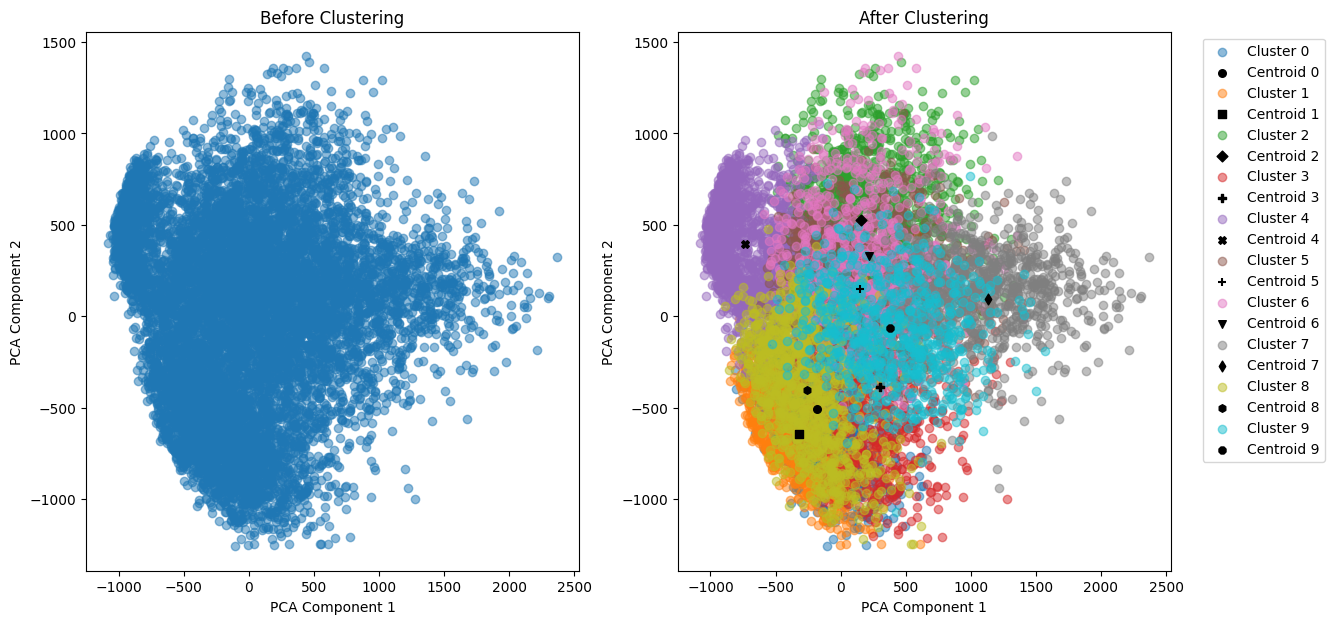

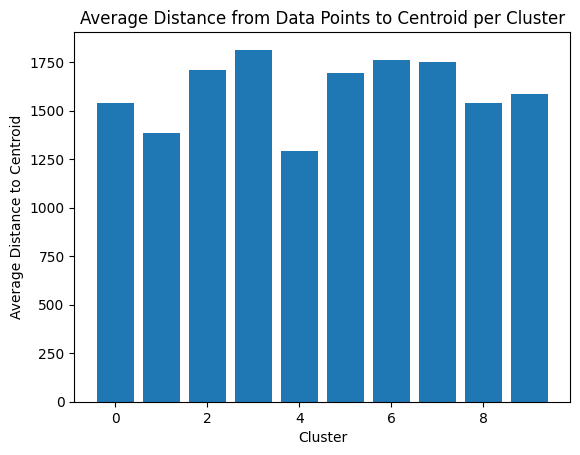

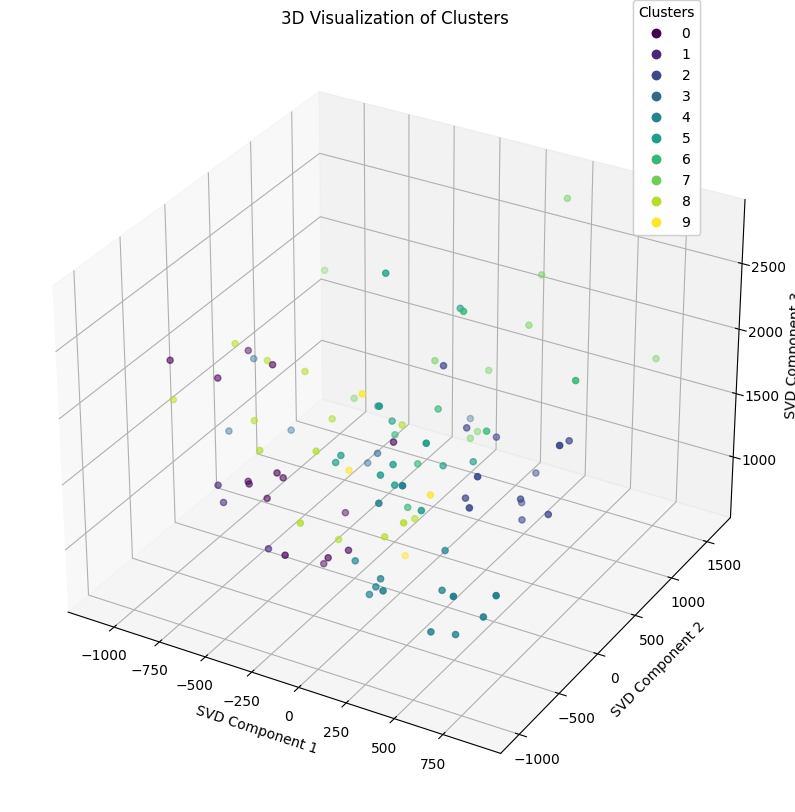

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
from pyspark.mllib.linalg import Vectors
import pandas as pd
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.sparse.linalg import svds


class MNISTKMeans:
    def __init__(self, file_path):
        self.spark = SparkSession.builder.appName("MNIST KMeans").getOrCreate()
        self.file_path = file_path
        self.data = None
        self.model = None
        self.transformed_data = None
        self.reduced_data = None

    def load_data(self):
        # Read CSV file
        df = self.spark.read.csv(self.file_path, header=False, inferSchema=True)
        # Assemble features
        feature_columns = [f"_c{i}" for i in range(1, 785)]
        self.assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
        self.data = self.assembler.transform(df).select("features")
        # Add index column
        self.data = self.data.withColumn("index", monotonically_increasing_id().cast("integer"))

    def assign_weights(self):
        # Assign weights to special rows
        special_indices = {0, 1, 2, 3, 4, 7, 8, 11, 18, 61}

        # Define a UDF for weight assignment
        def assign_weight(index):
            return 100.0 if index in special_indices else 1.0

        assign_weight_udf = udf(assign_weight, DoubleType())

        # Apply weights
        self.data = self.data.withColumn("weight", assign_weight_udf(self.data["index"]))

    def fit_kmeans(self, k=10):
        kmeans = KMeans().setK(k).setSeed(1).setWeightCol("weight")
        self.model = kmeans.fit(self.data)
        self.transformed_data = self.model.transform(self.data)

    def compute_average_distances(self):
        # Extract cluster centers and broadcast them
        cluster_centers = self.model.clusterCenters()
        bc_centers = self.spark.sparkContext.broadcast(cluster_centers)

        distances = self.transformed_data.rdd.map(
            lambda row: (row.prediction, float(np.linalg.norm(row.features.toArray() - bc_centers.value[row.prediction])))
        )
        distances_df = distances.toDF(["cluster", "distance"])
        avg_distances = distances_df.groupBy("cluster").avg("distance").collect()
        return sorted(avg_distances, key=lambda x: x[0])

    def plot_distances(self, avg_distances):
        clusters, distances = zip(*[(x["cluster"], x["avg(distance)"]) for x in avg_distances])
        plt.bar(clusters, distances)
        plt.xlabel("Cluster")
        plt.ylabel("Average Distance to Centroid")
        plt.title("Average Distance from Data Points to Centroid per Cluster")
        plt.show()

    def plot_clusters(self):
        transformed_pandas = self.transformed_data.select("features", "prediction").toPandas()
        transformed_pandas["features"] = transformed_pandas["features"].apply(lambda x: x.toArray())

        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(np.stack(transformed_pandas["features"].values))
        transformed_pandas["pca1"] = reduced_features[:, 0]
        transformed_pandas["pca2"] = reduced_features[:, 1]

        plt.figure(figsize=(14, 7))

        # Before clustering
        plt.subplot(1, 2, 1)
        plt.scatter(transformed_pandas["pca1"], transformed_pandas["pca2"], alpha=0.5)
        plt.title("Before Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")

        # After clustering with black centroids and number shapes
        plt.subplot(1, 2, 2)
        cluster_shapes = ['o', 's', 'D', 'P', 'X', '+', 'v', 'd', 'h', '8']  # Get 10 marker shapes

        for cluster in range(self.model.getK()):
            clustered_points = transformed_pandas[transformed_pandas["prediction"] == cluster]
            cluster_shape = cluster_shapes[cluster]  # Get shape for current cluster

            plt.scatter(clustered_points["pca1"], clustered_points["pca2"], alpha=0.5, label=f"Cluster {cluster}")

            # Get centroid for the current cluster
            centroid = self.model.clusterCenters()[cluster]
            centroid_pca = pca.transform(centroid.reshape(1, -1))  # Reshape for PCA

            # Plot the centroid as a black marker with the current shape
            plt.scatter(centroid_pca[0, 0], centroid_pca[0, 1], marker=cluster_shape, s=30, color="black", zorder=3, label=f"Centroid {cluster}")

        plt.title("After Clustering")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Move legend outside plot

        plt.show()

    def reduce_dimensions(self):
        # Convert to Pandas DataFrame
        pandas_df = self.transformed_data.select("features", "prediction").toPandas()

        # Extract features and convert to numpy array
        features = np.array(pandas_df['features'].tolist())

        # Apply SVD to reduce dimensions to 3 components
        U, S, VT = svds(features, k=3)

        # The reduced features will be U * S
        reduced_features = np.dot(U, np.diag(S))

        # Add the reduced dimensions back into the Pandas DataFrame
        pandas_df['svd1'] = reduced_features[:, 0]
        pandas_df['svd2'] = reduced_features[:, 1]
        pandas_df['svd3'] = reduced_features[:, 2]

        # Convert back to Spark DataFrame and cache
        self.reduced_data = self.spark.createDataFrame(pandas_df[['svd1', 'svd2', 'svd3', 'prediction']]).cache()

    def plot_3d_clusters(self):
        # Sample data points
        sampled_data = self.reduced_data.sample(False, 100 / self.reduced_data.count())

        # Ensure that exactly 100 points are sampled
        sampled_data = sampled_data.limit(100)
        sampled_pandas = sampled_data.toPandas()

        # Plot 3D graph
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(sampled_pandas["svd1"], sampled_pandas["svd2"], sampled_pandas["svd3"], c=sampled_pandas["prediction"], cmap='viridis')
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc='upper left', bbox_to_anchor=(0.8, 1.05))
        ax.add_artist(legend1)
        ax.set_xlabel("SVD Component 1")
        ax.set_ylabel("SVD Component 2")
        ax.set_zlabel("SVD Component 3")
        plt.title("3D Visualization of Clusters")
        plt.show()

    def run(self):
        self.load_data()
        #Task1
        self.assign_weights()
        self.fit_kmeans()
        avg_distances = self.compute_average_distances()
        self.plot_clusters()
        self.plot_distances(avg_distances)
        #Task2
        self.reduce_dimensions()
        self.plot_3d_clusters()

if __name__ == "__main__":
    mnist_kmeans = MNISTKMeans('/mnist_mini.csv')
    mnist_kmeans.run()

##References

[1] Apache Software Foundation, "pyspark.ml.clustering.KMeans," Apache Spark 3.2.0 Documentation, 2022. [Online]. Available: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.KMeans.html. [Accessed: May 10, 2024].

[2] Apache Software Foundation, "pyspark.ml.feature.VectorAssembler," Apache Spark 3.1.3 Documentation, 2022. [Online]. Available: https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html. [Accessed: May 10, 2024].

[3] Author's Name, “Singular Value Decomposition in PySpark MLlib,” Apache Software Foundation, 2022. [Online]. Available: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.linalg.distributed.SingularValueDecomposition.html. [Accessed: May 16, 2024].


# Task 3

**Collaborative filtering**  

Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. spark.ml currently supports model-based collaborative filtering, in which users and products are described by a small set of latent factors that can be used to predict missing entries. spark.ml uses the alternating least squares (ALS) algorithm to learn these latent factors. The implementation in spark.ml has the following parameters:  

* numBlocks is the number of blocks the users and items will be partitioned into in order to parallelize computation (defaults to 10).
* rank is the number of latent factors in the model (defaults to 10).
* maxIter is the maximum number of iterations to run (defaults to 10).
* regParam specifies the regularization parameter in ALS (defaults to 1.0).
* implicitPrefs specifies whether to use the explicit feedback ALS variant or one adapted for implicit feedback data (defaults to false which means using explicit feedback).
* alpha is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations (defaults to 1.0).
* nonnegative specifies whether or not to use nonnegative constraints for least squares (defaults to false).

**Pseudocode**  

INPUT: ratings2k.csv (dataset)
1. LOAD ratings2k.csv INTO Spark DataFrame
2. SPLIT DataFrame INTO training_data (70%) AND test_data (30%)
3. INITIALIZE ALS model WITH userCol="user", itemCol="item", ratingCol="rating"
4. DEFINE hyperparameter grid:
   * rank = [10, 11, ..., 20]
   * maxIter = [10, 15]
   * regParam = [0.01, 0.1, 0.2]
5. PERFORM Cross Validation on training_data USING ALS model and hyperparameter grid
6. SELECT best_model from Cross Validation
7. TRAIN best_model ON training_data
8. EVALUATE best_model ON test_data, STORE Mean Squared Error (MSE)
9. FOR EACH rank in [10, 11, ..., 20]:
   a. TRAIN new ALS model WITH current rank ON training_data
   b. EVALUATE model ON test_data, STORE MSE
10. VISUALIZE MSE for each rank IN A BAR CHART
11. GET recommendations FOR user_id = 1
12. GET recommendations FOR item_id = 1
13. PRINT recommendations

The Collaborative Filtering model was implemented using PySpark's Alternating Least Squares (ALS) algorithm. The dataset ratings2k.csv was used for this task, which was split into 70% training data and 30% test data.  A grid search with cross-validation was performed to find the optimal hyperparameters for the model, with the number of similar users (rank) ranging from 10 to 20.

The best model achieved a Mean Squared Error (MSE) of 1.0673 on the test set, with the following hyperparameters:

Rank: 10
Max Iterations: 15
Regularization Parameter: 0.2
The bar chart titled "MSE vs. Number of Similar Users" illustrates that there's minimal variation in the MSE across the different numbers of similar users (ranks) tested. This suggests that the model's performance is relatively stable regardless of the chosen number of similar users within this range.

Inference

The trained model was then used to generate recommendations:

Top 5 recommended items for user ID 1:

| User ID | Item ID | Predicted Rating |
|---|---|---|
| 1 | 429 | 5.02109 |
| 1 | 99  | 4.95935 |
| 1 | 28  | 4.81125 |
| 1 | 431 | 4.70624 |
| 1 | 437 | 4.67048 |

Top 5 recommended users for item ID 1:

| Item ID | User ID | Predicted Rating |
|---|---|---|
| 1 | 22 | 3.92443 |
| 1 | 28 | 3.81279 |
| 1 | 71 | 3.68715 |
| 1 | 58 | 3.64716 |
| 1 | 50 | 3.62109 |

**References**  
[1] “Collaborative Filtering - Spark 3.4.0 Documentation,” spark.apache.org. https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
‌

[2] AI-First, “1.4.4. The ALS Algorithm,” YouTube, Nov. 15, 2018. https://youtu.be/5im_ZSOZdxI?si=Kk_KcfktjCaDQf0g (accessed May 25, 2024).


[3] jamenlong1, “Recommendation Engines Using ALS in PySpark (MovieLens Dataset),” YouTube, Nov. 16, 2017. https://youtu.be/FgGjc5oabrA?si=RuB6nKcWUz2hQuYK (accessed May 25, 2024).
‌

Best Model MSE: 1.0114289130278107
Best Model Rank: 19
Best Model MaxIter: 5
Best Model RegParam: 0.3


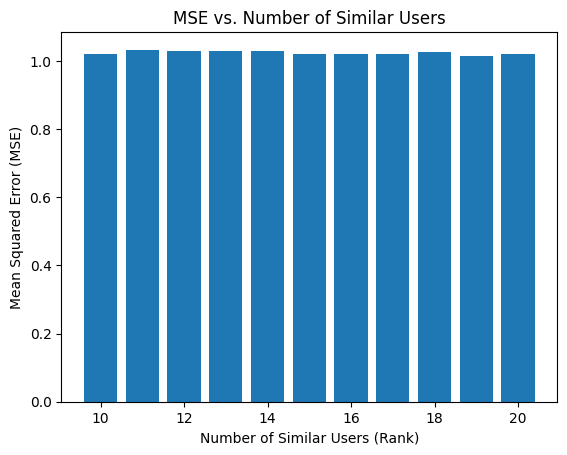

+----+----+---------+
|user|item|   rating|
+----+----+---------+
|   1|  99|4.6120863|
|   1| 355|4.5659475|
|   1| 354|4.5659475|
|   1| 335| 4.534049|
|   1| 376| 4.451712|
+----+----+---------+

+----+----+---------+
|item|user|   rating|
+----+----+---------+
|   1|  71|3.6747475|
|   1|  22|3.5192468|
|   1|  48|  3.50413|
|   1|  49|3.4997563|
|   1|  50|3.4821389|
+----+----+---------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, explode, array
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

class CollaborativeFiltering:
    def __init__(self, file_path):
        self.spark = SparkSession.builder.appName("CollaborativeFiltering").getOrCreate()
        self.file_path = file_path
        self.data = None
        self.train_data = None
        self.test_data = None
        self.best_model = None
        self.evaluator = RegressionEvaluator(metricName="mse", labelCol="rating", predictionCol="prediction")
        self.results = {}

    def load_data(self):
        self.data = self.spark.read.csv(self.file_path, header=True, inferSchema=True).select("user", "item", "rating")

    def split_data(self, train_ratio=0.7):
        self.train_data, self.test_data = self.data.randomSplit([train_ratio, 1 - train_ratio])

    def tune_model(self):
        als = ALS(userCol="user", itemCol="item", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)
        param_grid = (ParamGridBuilder()
                      .addGrid(als.rank, range(10, 21))
                      .addGrid(als.maxIter, [4, 5, 6])
                      .addGrid(als.regParam, [0.28, 0.29, 0.3])
                      .build())
        cv = CrossValidator(estimator=als,
                            estimatorParamMaps=param_grid,
                            evaluator=self.evaluator,
                            numFolds=3)
        cv_model = cv.fit(self.train_data)
        self.best_model = cv_model.bestModel
        for params in cv_model.getEstimatorParamMaps():
            rank = params[als.rank]
            model = als.copy(params).fit(self.train_data)
            predictions = model.transform(self.test_data)
            mse = self.evaluator.evaluate(predictions)
            self.results[rank] = mse

    def evaluate_model(self):
        predictions = self.best_model.transform(self.test_data)
        mse = self.evaluator.evaluate(predictions)
        return mse

    def run_experiment(self):
        self.tune_model()
        mse = self.evaluate_model()
        print(f"Best Model MSE: {mse}")
        print(f"Best Model Rank: {self.best_model.rank}")
        print(f"Best Model MaxIter: {self.best_model._java_obj.parent().getMaxIter()}")
        print(f"Best Model RegParam: {self.best_model._java_obj.parent().getRegParam()}")
        return mse

    def visualize_results(self):
        ranks = list(self.results.keys())
        mses = list(self.results.values())
        plt.bar(ranks, mses)
        plt.xlabel('Number of Similar Users (Rank)')
        plt.ylabel('Mean Squared Error (MSE)')
        plt.title('MSE vs. Number of Similar Users')
        plt.show()

    def recommend_for_user(self, user_id, num_recommendations=5):
        user_rated_items = self.data.filter(col("user") == user_id).select("item").rdd.flatMap(lambda x: x).collect()
        user_subset = self.spark.createDataFrame([(user_id,)], ["user"])
        recommendations = self.best_model.recommendForUserSubset(user_subset, num_recommendations * 2)

        recommendations = recommendations.selectExpr("user", "explode(recommendations) as rec")\
                                            .select("user", col("rec.item").alias("item"), col("rec.rating").alias("rating"))\
                                            .filter(~col("item").isin(user_rated_items))\
                                            .limit(num_recommendations)

        recommendations.show()

    def recommend_for_item(self, item_id, num_recommendations=5):
        item_rated_users = self.data.filter(col("item") == item_id).select("user").rdd.flatMap(lambda x: x).collect()
        item_subset = self.spark.createDataFrame([(item_id,)], ["item"])
        recommendations = self.best_model.recommendForItemSubset(item_subset, num_recommendations * 2)

        recommendations = recommendations.selectExpr("item", "explode(recommendations) as rec")\
                                            .select("item", col("rec.user").alias("user"), col("rec.rating").alias("rating"))\
                                            .filter(~col("user").isin(item_rated_users))\
                                            .limit(num_recommendations)

        recommendations.show()

    def stop_spark(self):
        self.spark.stop()

if __name__ == "__main__":
    file_path = "/content/ratings2k.csv"
    cf = CollaborativeFiltering(file_path)
    cf.load_data()
    cf.split_data()
    mse = cf.run_experiment()
    cf.visualize_results()

    # Inference to visualize model operations
    cf.recommend_for_user(user_id=1, num_recommendations=5)
    cf.recommend_for_item(item_id=1, num_recommendations=5)

    cf.stop_spark()


# Task 4

Mean Squared Error (MSE) in train set = 0.0005726963310780723
Mean Squared Error (MSE) in test set = 0.0006470928143897643


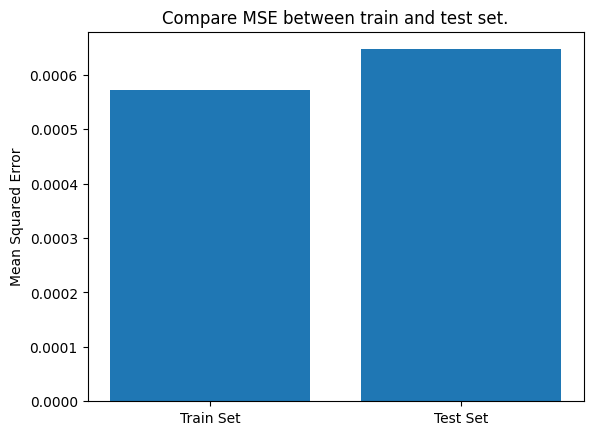

Price fluctuation range of the next day: -0.005366253477302886


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import array_to_vector
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lag, when, to_date, array, lit
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

class StockRangePredictor:
    def __init__(self, data_path):
        self.spark = SparkSession.builder.appName("StockRangePrediction").getOrCreate()
        self.data_path = data_path

    def load_and_preprocess_data(self, k=5):
        df = self.spark.read.csv(self.data_path, header=True, inferSchema=True)

        df = df.withColumn("Ngay", to_date(col("Ngay"), "dd/MM/yyyy")) \
               .withColumnRenamed("Ngay", "date") \
               .withColumnRenamed("HVN", "value")


        # Calculate fluctuation by formula
        window = Window.orderBy("date")
        df = df.withColumn("prev_value", lag("value", 1).over(window))
        df = df.withColumn("fluctuation", when(col("prev_value").isNull(), 0.0).otherwise(
            (col("value") - col("prev_value")) / col("prev_value")))

        # Feature and label
        df = df.withColumn("ranges_of_k_previous_dates",
                          array([
                              when(lag("fluctuation", i).over(window).isNull(), lit(0.0))
                              .otherwise(lag("fluctuation", i).over(window))
                              for i in range(1, k+1)
                          ]))
        df = df.withColumn("today_range", col("fluctuation"))
        df = df.dropna()

        # split data to train and test
        train_data = df.filter(df["date"] < "2022-07-01")
        test_data = df.filter(df["date"] >= "2022-07-01")
        return train_data, test_data

    def train_and_evaluate_model(self, train_data, test_data):
        train_data = train_data.withColumn("features", array_to_vector("ranges_of_k_previous_dates"))
        test_data = test_data.withColumn("features", array_to_vector("ranges_of_k_previous_dates"))

        lr = LinearRegression(featuresCol="features", labelCol="today_range")
        model = lr.fit(train_data)

        predictions_train = model.transform(train_data)
        predictions_test = model.transform(test_data)

        evaluator = RegressionEvaluator(labelCol="today_range", predictionCol="prediction", metricName="mse")
        mse_train = evaluator.evaluate(predictions_train)
        mse_test = evaluator.evaluate(predictions_test)

        print("Mean Squared Error (MSE) in train set =", mse_train)
        print("Mean Squared Error (MSE) in test set =", mse_test)


        return mse_train, mse_test, model


    def visualize_results(self, mse_train, mse_test):
        plt.bar(["Train Set", "Test Set"], [mse_train, mse_test])
        plt.ylabel("Mean Squared Error")
        plt.title("Compare MSE between train and test set.")
        plt.show()


    # Save model
    def saved_model(self, model):
        !rm -rf output
        !mkdir output
        model.save('/content/output/stock.model')

    def load_model(self):
        return LinearRegressionModel.load('/content/output/stock.model')


    def predict_next_day_range(self, model, last_k_days_fluctuations):
        prediction_input_df = self \
        .spark \
        .createDataFrame([(last_k_days_fluctuations,)], \
        ["ranges_of_k_previous_dates"]) \
        .withColumn("features", \
        array_to_vector("ranges_of_k_previous_dates"))

        # Predict
        prediction = model.transform(prediction_input_df).select("prediction").first()[0]
        return prediction


if __name__ == "__main__":
    predictor = StockRangePredictor("/content/stockHVN2022.csv")
    train_data, test_data = predictor.load_and_preprocess_data(k=5)
    mse_train, mse_test, model = predictor.train_and_evaluate_model(train_data, test_data)
    predictor.visualize_results(mse_train, mse_test)
    predictor.saved_model(model)
    my_model = predictor.load_model()

    # predict the price fluctuation range of the next day based on k day before
    last_k_days_fluctuations = [-0.01, 0.02, -0.005, 0.015, -0.02]
    next_day_range_prediction = predictor.predict_next_day_range(my_model, last_k_days_fluctuations)
    print("Price fluctuation range of the next day:", next_day_range_prediction)

#Task5

This task focuses on applying various multi-class classification models to the MNIST dataset of handwritten digits. The goal is to accurately predict the digit represented in an image based on its pixel values. PySpark was used for model implementation and evaluation, and matplotlib for visualizing the results.

**Methods**  
The following classification models were implemented:

Multilayer Perceptron (MLP): A neural network architecture with multiple hidden layers, used for learning complex patterns in data.
Random Forest (RF): An ensemble method that combines multiple decision trees for improved accuracy and robustness.
Linear Support Vector Machine (LinearSVC): A linear classifier that aims to find an optimal hyperplane to separate data points of different classes.
Pseudocode

INPUT: mnist_mini.csv (dataset)

1.  LOAD mnist_mini.csv INTO Spark DataFrame
2.  RENAME columns TO 'label' AND 'pixel0' to 'pixel783'
3.  ASSEMBLE pixel columns INTO 'features' vector
4.  SPLIT DataFrame INTO train_data (80%) AND test_data (20%)
5.  INITIALIZE classifiers:
    *   MultilayerPerceptronClassifier
    *   RandomForestClassifier
    *   LinearSVC (WITH binary labels)
6.  FOR EACH classifier:
    a.  IF LinearSVC, PREPARE binary_data with label 1 for '1' and 0 for others
    b.  TRAIN classifier ON train_data (or binary_data)
    c.  EVALUATE classifier ON train_data AND test_data (or binary_data equivalents), STORE accuracy
7.  PRINT accuracy results FOR each classifier
8.  VISUALIZE train_accuracy AND test_accuracy IN A TWIN-BAR CHART
Implementation and Results
The code implementation followed an object-oriented approach with a MNISTClassifier class to handle the training and evaluation of each model. The dataset was preprocessed to assemble pixel values into feature vectors and split into training and test sets. Notably, the LinearSVC required binary labels (1 for digit '1', 0 for others) due to its inherent nature.

**Accuracy Results:**

| Classifier | Train Accuracy | Test Accuracy |
|---|---|---|
| Multilayer Perceptron | 0.9415 | 0.9198 |
| Random Forest | 0.9926 | 0.9505 |
| LinearSVC | 0.9938 | 0.9943 |

**Reference**  
[1] “Classification and regression - Spark 3.3.1 Documentation,” spark.apache.org. https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier  
‌[2]  “Classification and regression - Spark 2.4.5 Documentation,” spark.apache.org. https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier  
[3] “Classification and regression - Spark 3.4.1 Documentation,” spark.apache.org. https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine
‌

MultilayerPerceptron - Training Accuracy: 0.9415, Test Accuracy: 0.9198
RandomForest - Training Accuracy: 0.9926, Test Accuracy: 0.9505
LinearSVC - Training Accuracy: 0.9938, Test Accuracy: 0.9943


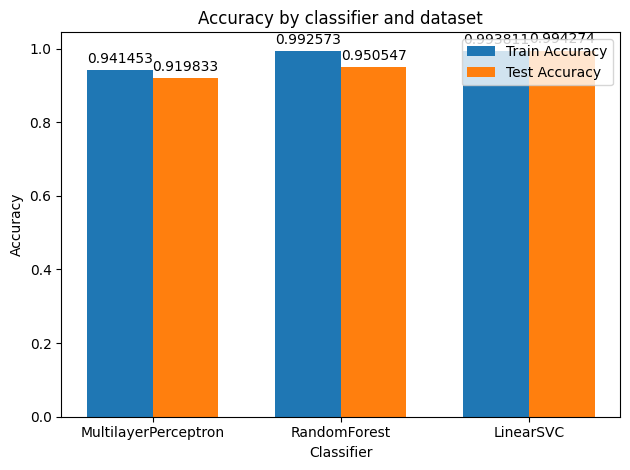

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np

class MNISTClassifier:
    def __init__(self, classifier, name):
        self.classifier = classifier
        self.name = name
        self.model = None
        self.train_accuracy = None
        self.test_accuracy = None

    def train(self, train_data):
        self.model = self.classifier.fit(train_data)

    def evaluate(self, train_data, test_data):
        evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

        train_predictions = self.model.transform(train_data)
        self.train_accuracy = evaluator.evaluate(train_predictions)

        test_predictions = self.model.transform(test_data)
        self.test_accuracy = evaluator.evaluate(test_predictions)

        return self.train_accuracy, self.test_accuracy

    def get_results(self):
        return {
            "train_accuracy": self.train_accuracy,
            "test_accuracy": self.test_accuracy
        }

    def run_classification(file_path):
        # Initialize Spark session
        spark = SparkSession.builder.appName("MNIST_Classification").getOrCreate()

        # Load data
        data = spark.read.csv(file_path, header=False, inferSchema=True)

        # Rename columns
        columns = ['label'] + [f'pixel{i}' for i in range(784)]
        data = data.toDF(*columns)

        # Assemble features into a feature vector
        assembler = VectorAssembler(inputCols=[f'pixel{i}' for i in range(784)], outputCol='features')
        data = assembler.transform(data).select('features', 'label')

        # Split data into training and test sets
        train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

        # Define classifiers
        classifiers = {
            "MultilayerPerceptron": MNISTClassifier(MultilayerPerceptronClassifier(layers=[784, 128, 64, 10], seed=42, blockSize=128, maxIter=100), "MultilayerPerceptron"),
            "RandomForest": MNISTClassifier(RandomForestClassifier(numTrees=100, maxDepth=10, seed=42), "RandomForest"),
            "LinearSVC": MNISTClassifier(LinearSVC(maxIter=100, regParam=0.1), "LinearSVC")
        }

        # Train and evaluate classifiers
        for name, classifier in classifiers.items():
            if name == "LinearSVC":
                # Transform labels: if label == 1, keep it as 1, otherwise set it to 0
                binary_data = data.withColumn('label', when(data.label == 1, 1).otherwise(0))
                train_data_binary, test_data_binary = binary_data.randomSplit([0.8, 0.2], seed=42)
                classifier.train(train_data_binary)
                classifier.evaluate(train_data_binary, test_data_binary)
            else:
                classifier.train(train_data)
                classifier.evaluate(train_data, test_data)
            print(f"{name} - Training Accuracy: {classifier.train_accuracy:.4f}, Test Accuracy: {classifier.test_accuracy:.4f}")

        # Prepare data for plotting
        labels = list(classifiers.keys())
        train_accuracies = [classifier.train_accuracy for classifier in classifiers.values()]
        test_accuracies = [classifier.test_accuracy for classifier in classifiers.values()]

        x = np.arange(len(labels))  # the label locations
        width = 0.35  # the width of the bars

        fig, ax = plt.subplots()
        rects1 = ax.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
        rects2 = ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_xlabel('Classifier')
        ax.set_ylabel('Accuracy')
        ax.set_title('Accuracy by classifier and dataset')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()

if __name__ == "__main__":
    MNISTClassifier.run_classification('/content/mnist_mini.csv')
